In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from numpy import set_printoptions
import pandas as pd
import os
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from rdkit import Chem
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression                         
from sklearn.tree import DecisionTreeClassifier                             
from sklearn.neighbors import KNeighborsClassifier                          
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        
from sklearn.naive_bayes import GaussianNB                                  
from sklearn.svm import SVC    
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
df_rdkit = pd.read_csv("./BBBP_rdkit_descriptors.csv") 
print(df_rdkit.head())

                   name  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0            Propanolol          -1.425736       -1.425736          -1.033793   
1  Terbutylchlorambucil           0.219570        0.219570          -0.153893   
2                 40730           1.344959        1.344959          -0.708376   
3                    24          -0.158356       -0.158356           0.079856   
4           cloxacillin           0.506100        0.506100          -0.571094   

   MinEStateIndex       qed       SPS     MolWt  HeavyAtomMolWt  ExactMolWt  \
0        0.169637  1.142390 -0.699446 -0.330203       -0.343124   -0.332216   
1       -0.105149 -0.728434 -0.589675  0.104827        0.078605    0.099851   
2        0.275672  1.218782 -0.090272  0.111785        0.136069    0.113155   
3        0.184496  0.780910  0.116675 -0.359383       -0.410026   -0.358311   
4        0.496385  0.413080 -0.205325  0.606523        0.678746    0.604408   

   ...  fr_quatN  fr_sulfide  fr_sulfo

In [19]:
description = df_rdkit.describe()
print(description)

       MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
count       2.039000e+03    2.039000e+03       2.039000e+03    2.039000e+03   
mean        2.822656e-16    2.822656e-16       7.666474e-17    4.739275e-16   
std         1.000245e+00    1.000245e+00       1.000245e+00    1.000245e+00   
min        -2.167431e+00   -2.167431e+00      -1.033793e+00   -3.551296e+00   
25%        -1.017520e+00   -1.017520e+00      -7.477199e-01   -5.749626e-01   
50%         2.117711e-01    2.117711e-01      -2.145794e-01    5.986796e-02   
75%         6.031850e-01    6.031850e-01       3.317169e-01    5.928307e-01   
max         2.950001e+00    2.950001e+00       5.148249e+00    5.135854e+00   

                qed           SPS         MolWt  HeavyAtomMolWt    ExactMolWt  \
count  2.039000e+03  2.039000e+03  2.039000e+03    2.039000e+03  2.039000e+03   
mean   8.363426e-17  2.265095e-16  4.181713e-17   -3.763542e-16 -2.927199e-16   
std    1.000245e+00  1.000245e+00  1.000245e+

 <span style="color:red;"> Data loading and cleaning


In [20]:
df_cleaned = df_rdkit.drop(columns=['name'], errors='ignore')


In [21]:
#correlation-based feature reduction
corr = df_cleaned.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_uncorrelated = df_cleaned.drop(columns=to_drop)

In [22]:
# Removing features with low variance: 
X_all =  df_uncorrelated.drop(columns=['p_np'])
Y_all =  df_uncorrelated['p_np']
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X_all)

array([[-1.42573583e+00, -1.03379256e+00,  1.69636574e-01, ...,
        -1.47912776e-01, -1.25082991e-01, -2.07342716e-01],
       [ 2.19569832e-01, -1.53892966e-01, -1.05148510e-01, ...,
        -1.47912776e-01, -1.25082991e-01, -2.07342716e-01],
       [ 1.34495948e+00, -7.08376208e-01,  2.75672239e-01, ...,
        -1.47912776e-01, -1.25082991e-01, -2.07342716e-01],
       ...,
       [ 7.15839153e-02, -7.77933906e-01,  6.45646180e-01, ...,
        -1.47912776e-01, -1.25082991e-01,  4.70860842e+00],
       [-1.17381425e+00, -8.12514088e-01,  4.97581494e-01, ...,
        -1.47912776e-01, -1.25082991e-01, -2.07342716e-01],
       [-3.50971015e-03,  3.70520467e-01,  2.19274859e-01, ...,
        -1.47912776e-01, -1.25082991e-01, -2.07342716e-01]])

<span style="color:red;"> Univariate feature selection:

This selects features most strongly related to the target (based on F-score) using ANOVA F-test.

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Select top k features using ANOVA F-test
k = 30  # or any number of top features you want
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_all, Y_all)

# Get selected feature names
mask = selector.get_support()  # boolean mask of selected features
selected_features = X_all.columns[mask]

# Show selected features and their F-scores
scores = selector.scores_[mask]
feature_scores = pd.Series(scores, index=selected_features).sort_values(ascending=False)
print(" Top features selected using ANOVA F-test:\n")
print(feature_scores)

 Top features selected using ANOVA F-test:

TPSA                        788.629942
NHOHCount                   562.646977
PEOE_VSA10                  553.447215
PEOE_VSA1                   511.773223
qed                         501.676703
fr_lactam                   431.581086
SMR_VSA2                    409.392054
EState_VSA8                 401.642412
SlogP_VSA2                  391.372963
VSA_EState2                 302.967718
NumRotatableBonds           278.239078
MolWt                       271.909432
SlogP_VSA3                  257.225837
PEOE_VSA13                  249.624189
fr_sulfide                  234.912251
fr_Al_COO                   232.838634
VSA_EState3                 230.103367
MolLogP                     209.148996
Phi                         207.898041
PEOE_VSA12                  205.081367
NumAtomStereoCenters        191.957413
EState_VSA10                185.270050
fr_Al_OH                    178.272041
HallKierAlpha               173.931528
fr_Ar_OH            

In [24]:

selected_features_30 = [
    "TPSA", "NHOHCount", "PEOE_VSA10", "PEOE_VSA1", "qed", "fr_lactam", "SMR_VSA2", "EState_VSA8", "SlogP_VSA2",
    "VSA_EState2", "NumRotatableBonds", "MolWt", "SlogP_VSA3", "PEOE_VSA13", "fr_sulfide", "fr_Al_COO",
    "VSA_EState3", "MolLogP", "Phi", "PEOE_VSA12", "NumAtomStereoCenters", "EState_VSA10", "fr_Al_OH",
    "HallKierAlpha", "fr_Ar_OH", "PEOE_VSA9", "PEOE_VSA5", "NumSaturatedHeterocycles", "SMR_VSA10", "PEOE_VSA2"
]

# Create a new dataset with just these features + target
selected_df = df_cleaned[selected_features_30 + ['p_np']].copy()



In [25]:

array = selected_df.values
X = selected_df.drop(columns=['p_np'])
y = selected_df['p_np']

corr_matrix = X.corr()

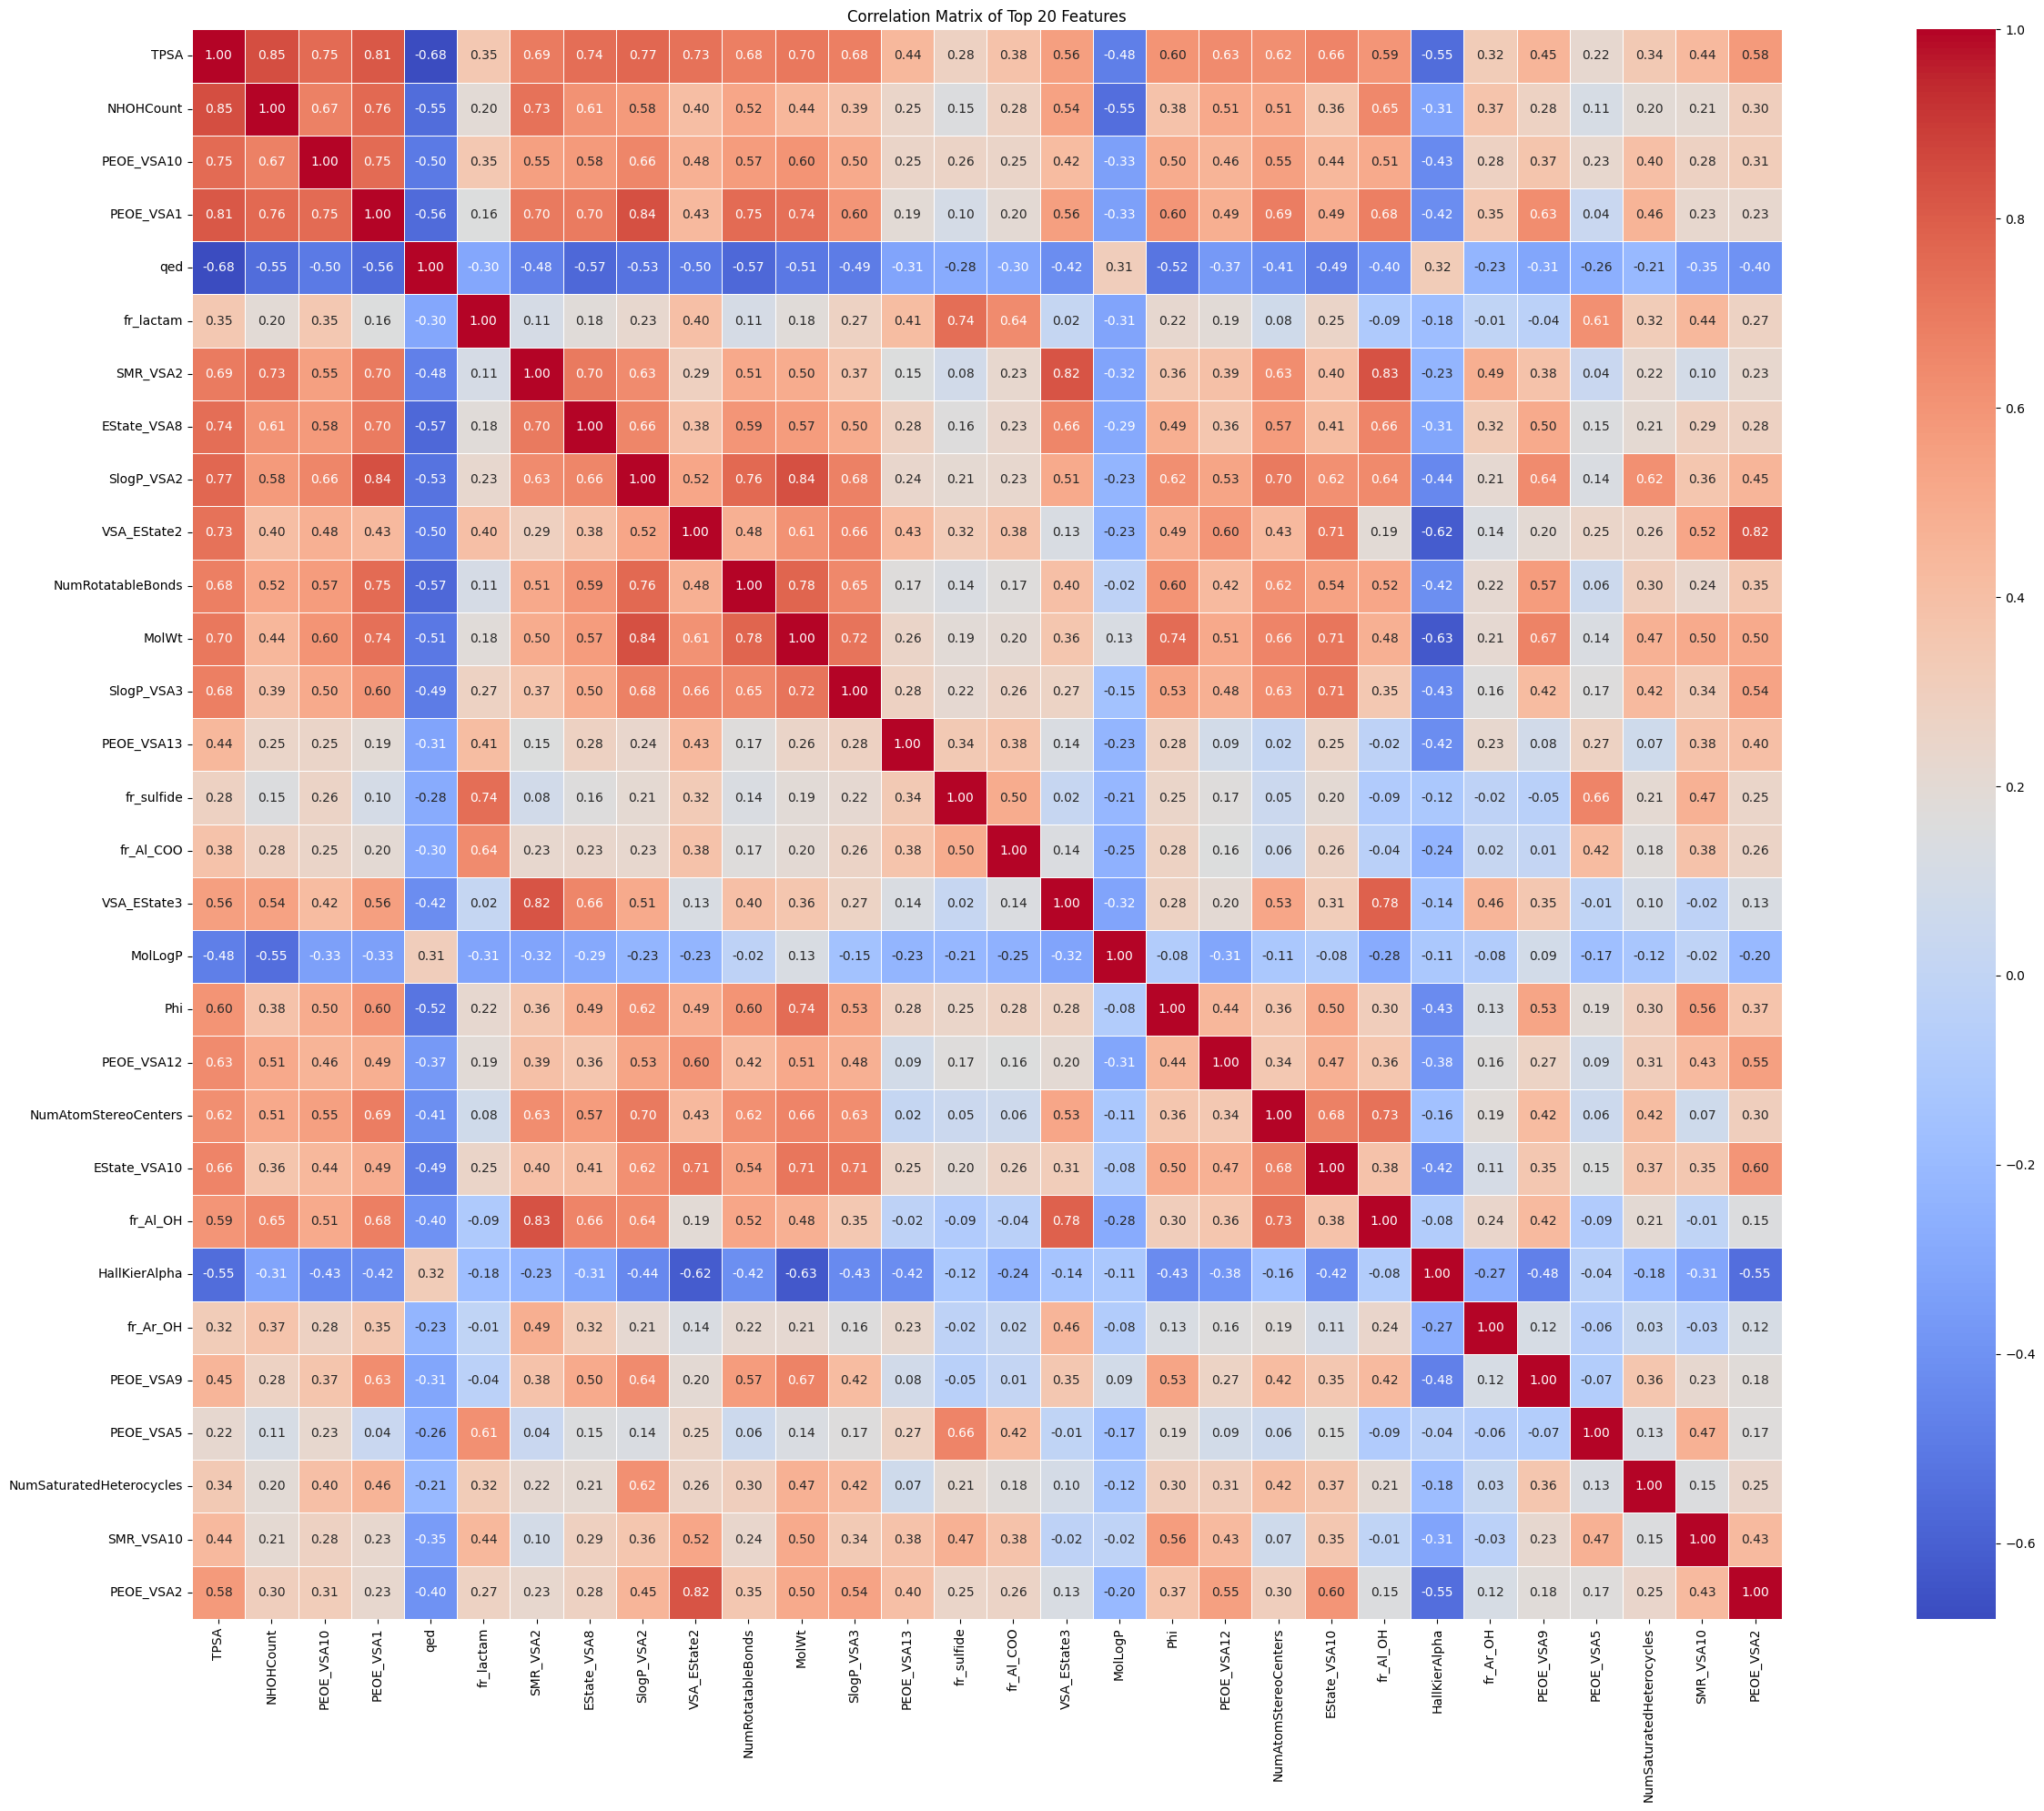

In [26]:
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Top 20 Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:

X_all =  df_uncorrelated.drop(columns=['p_np'])
Y_all =  df_uncorrelated['p_np']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

 <span style="color:red;"> BENCHMARK COMPARISON
 
 Benchmark comparison of multiple machine learning models using cross-validation, and evaluating them based on ROC-AUC and F1-score.

In [28]:

# prepare models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=500)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))  # Important: probability=True for SVC

# evaluate each model
roc_results = []
f1_results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)

    # ROC-AUC
    cv_roc = cross_val_score(model, X_scaled, Y_all, cv=kfold, scoring='roc_auc')
    roc_results.append(cv_roc)

    # F1-Score
    cv_f1 = cross_val_score(model, X_scaled, Y_all, cv=kfold, scoring='f1')
    f1_results.append(cv_f1)

    names.append(name)
    
    print(f"{name}:")
    print(f"  ROC-AUC Mean: {cv_roc.mean():.3f} (Std: {cv_roc.std():.3f})")
    print(f"  F1-Score Mean: {cv_f1.mean():.3f} (Std: {cv_f1.std():.3f})\n")

LR:
  ROC-AUC Mean: 0.887 (Std: 0.028)
  F1-Score Mean: 0.918 (Std: 0.013)

LDA:
  ROC-AUC Mean: 0.888 (Std: 0.026)
  F1-Score Mean: 0.922 (Std: 0.014)

KNN:
  ROC-AUC Mean: 0.899 (Std: 0.030)
  F1-Score Mean: 0.927 (Std: 0.011)

CART:
  ROC-AUC Mean: 0.780 (Std: 0.024)
  F1-Score Mean: 0.894 (Std: 0.009)

NB:
  ROC-AUC Mean: 0.820 (Std: 0.044)
  F1-Score Mean: 0.888 (Std: 0.017)

SVM:
  ROC-AUC Mean: 0.917 (Std: 0.017)
  F1-Score Mean: 0.927 (Std: 0.011)



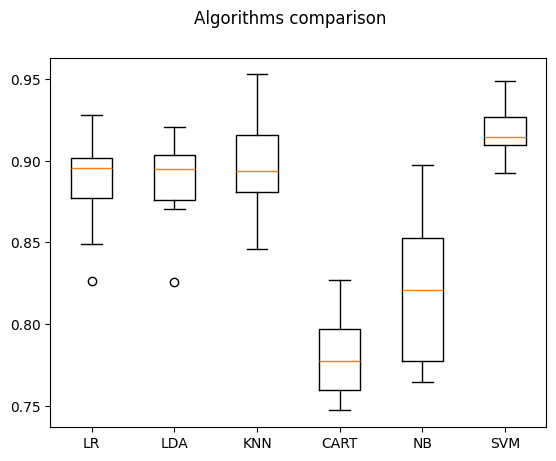

In [29]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithms comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(roc_results)
ax.set_xticklabels(names)
pyplot.show()

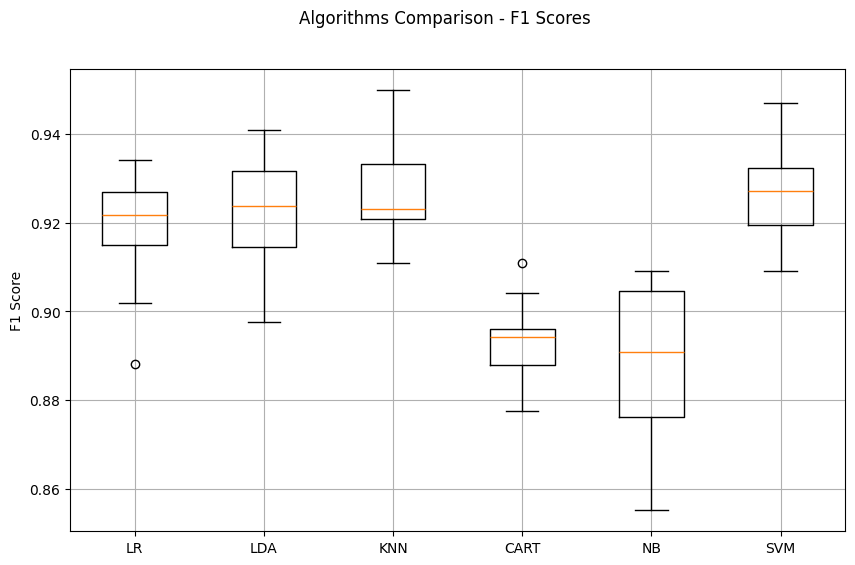

In [30]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithms Comparison - F1 Scores')
ax = fig.add_subplot(111)
plt.boxplot(f1_results)
ax.set_xticklabels(names)
plt.ylabel('F1 Score')
plt.grid()
plt.show()

<span style="color:red;">Imbalanced classification

Imbalanced classification strategy comparison for logistic regression

 LogisticRegression with class_weight='balanced'
Accuracy: 0.874
ROC-AUC: 0.884
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.64      0.71       479
           1       0.90      0.95      0.92      1560

    accuracy                           0.87      2039
   macro avg       0.84      0.79      0.81      2039
weighted avg       0.87      0.87      0.87      2039

 LogisticRegression with class_weight='balanced'
Accuracy: 0.853
ROC-AUC: 0.885
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71       479
           1       0.93      0.88      0.90      1560

    accuracy                           0.85      2039
   macro avg       0.79      0.83      0.81      2039
weighted avg       0.86      0.85      0.86      2039


 LogisticRegression with SMOTE
Accuracy: 0.844
ROC-AUC: 0.88
Classification Report:
               precision    recall  f1-score   suppor

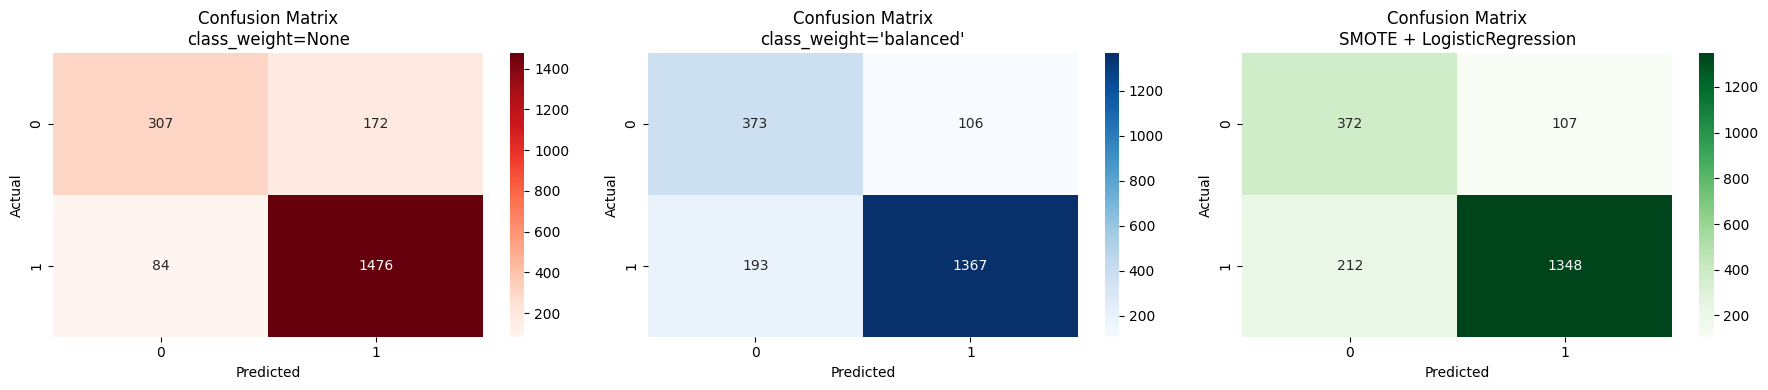

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, Y_all, test_size=0.2, stratify=Y_all, random_state=42
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# ----- 1. Logistic Regression with class_weight=none -----
# On imbalanced datasets, it tends to favor the majority class.

model_none = LogisticRegression(solver='lbfgs', max_iter=300, class_weight=None)

y_pred_none= cross_val_predict(model_none, X_scaled, Y_all, cv=cv)
y_prob_none = cross_val_predict(model_none, X_scaled, Y_all, cv=cv, method='predict_proba')[:, 1]

acc_n = accuracy_score(Y_all, y_pred_none)
roc_n = roc_auc_score(Y_all, y_prob_none)
print(" LogisticRegression with class_weight='balanced'")
print("Accuracy:", round(acc_n, 3))
print("ROC-AUC:", round(roc_n, 3))
print("Classification Report:\n", classification_report(Y_all, y_pred_none))

# ----- 2. Logistic Regression with class_weight='balanced' -----
#  The “balanced” mode uses the values of y to automatically adjust weights 
#  inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).


model_weighted = LogisticRegression(solver='lbfgs', max_iter=300, class_weight='balanced')

y_pred_weighted = cross_val_predict(model_weighted, X_scaled, Y_all, cv=cv)
y_prob_weighted = cross_val_predict(model_weighted, X_scaled, Y_all, cv=cv, method='predict_proba')[:, 1]

acc_w = accuracy_score(Y_all, y_pred_weighted)
roc_w = roc_auc_score(Y_all, y_prob_weighted)
print(" LogisticRegression with class_weight='balanced'")
print("Accuracy:", round(acc_w, 3))
print("ROC-AUC:", round(roc_w, 3))
print("Classification Report:\n", classification_report(Y_all, y_pred_weighted))


# ----- 3. SMOTE + Logistic Regression -----
# Applies SMOTE within cross-validation folds to generate synthetic minority samples: DOI: https://doi.org/10.1613/jair.953

smote = SMOTE(random_state=42)
model_smote = LogisticRegression(solver='lbfgs', max_iter=300)

pipeline = Pipeline([
    ('smote', smote),
    ('logreg', model_smote)
])

y_pred_smote = cross_val_predict(pipeline, X_scaled, Y_all, cv=cv)
y_prob_smote = cross_val_predict(pipeline, X_scaled, Y_all, cv=cv, method='predict_proba')[:, 1]

acc_s = accuracy_score(Y_all, y_pred_smote)
roc_s = roc_auc_score(Y_all, y_prob_smote)
print("\n LogisticRegression with SMOTE")
print("Accuracy:", round(acc_s, 3))
print("ROC-AUC:", round(roc_s, 3))
print("Classification Report:\n", classification_report(Y_all, y_pred_smote))


# ----- Confusion Matrices -----

fig, axs = plt.subplots(1, 3, figsize=(18, 4))  

cm_none = confusion_matrix(Y_all, y_pred_none)
sns.heatmap(cm_none, annot=True, fmt='d', cmap='Reds', ax=axs[0])
axs[0].set_title("Confusion Matrix\nclass_weight=None")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")


cm_weighted = confusion_matrix(Y_all, y_pred_weighted)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion Matrix\nclass_weight='balanced'")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

cm_smote = confusion_matrix(Y_all, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axs[2])
axs[2].set_title("Confusion Matrix\nSMOTE + LogisticRegression")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


<small><i>
From the plot we can see clearly that without balancing we have:\
High FN: model is misclassifying many BBB− as BBB+ \
Low TN:  model rarely predicts class 0 correctly \
High TP:  model may be blindly favoring class 1

Using class_weight='balanced\
Forces the model to pay attention to both classes, even when one is smaller.

Using SMOTE:\
Creates synthetic examples of the minority class (class 0) during training. Gives the model more balanced data to learn from in each fold. Reference; https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Unbalanced model biases heavily toward class 1 and ignores class 0. had high recall for class 1 but terrible performance on class 0 (missed many non-penetrants).\
Balanced and SMOTE models give more useful, realistic results, with much better treatment of non-penetrant compounds (class 0).\
Balanced and SMOTE:\
Correctly identified more class 0 compounds.
Gave lower but more reliable accuracy.
Produced better confusion matrices (more TNs, fewer FNs for class 0).
<small><i>

<span style="color:red;">Comparing 3 SVM Models:

Untuned SVM (default params)\
SVM tuned with GridSearchCV\
SVM tuned with Genetic Algorithm

And for each version:\
Trains the model\
Evaluates with classification_report and ROC AUC\
Records and plots training time and ROC AUC


 Untuned SVM
              precision    recall  f1-score   support

           0       0.91      0.61      0.73        96
           1       0.89      0.98      0.93       312

    accuracy                           0.89       408
   macro avg       0.90      0.80      0.83       408
weighted avg       0.90      0.89      0.89       408

ROC AUC: 0.9366653311965811

 SVM with GridSearchCV
              precision    recall  f1-score   support

           0       0.85      0.66      0.74        96
           1       0.90      0.96      0.93       312

    accuracy                           0.89       408
   macro avg       0.88      0.81      0.84       408
weighted avg       0.89      0.89      0.89       408

ROC AUC: 0.9404380341880342
Best Params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

 SVM with Genetic Algorithm
              precision    recall  f1-score   support

           0       0.85      0.66      0.74        96
           1       0.90      0.96      0.93       312

    

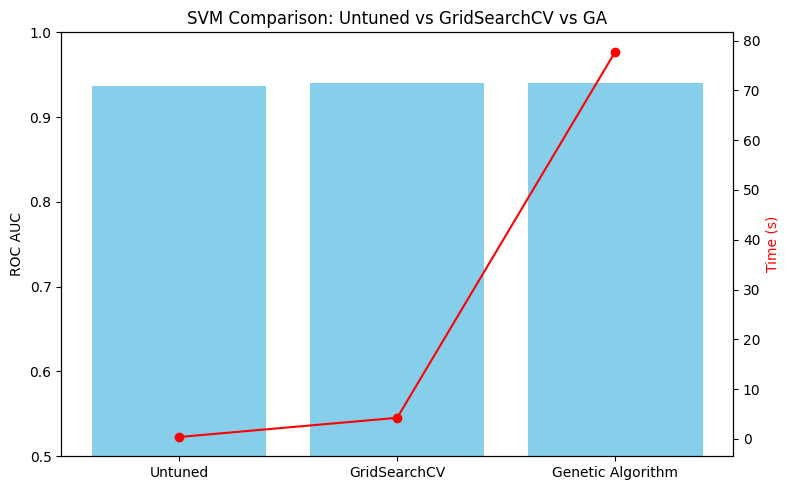

In [32]:

import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import VarianceThreshold



# ===========================
#  Comparison Configuration
# ===========================
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Track results
results = {}

# ===============================
# 1. Untuned SVM
# ===============================
start = time.time()
svm_untuned = SVC(probability=True, random_state=42)
svm_untuned.fit(X_train_scaled, y_train)
y_pred = svm_untuned.predict(X_test_scaled)
y_prob = svm_untuned.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
end = time.time()

results["Untuned"] = {
    "auc": auc,
    "time": end - start,
    "report": classification_report(y_test, y_pred)
}
print("\n Untuned SVM")
print(results["Untuned"]["report"])
print("ROC AUC:", auc)

# ===============================
# 2. GridSearchCV
# ===============================
start = time.time()
grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_svm_grid = grid.best_estimator_
y_pred = best_svm_grid.predict(X_test_scaled)
y_prob = best_svm_grid.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
end = time.time()

results["GridSearchCV"] = {
    "auc": auc,
    "time": end - start,
    "report": classification_report(y_test, y_pred),
    "best_params": grid.best_params_
}
print("\n SVM with GridSearchCV")
print(results["GridSearchCV"]["report"])
print("ROC AUC:", auc)
print("Best Params:", grid.best_params_)

# ===============================
# 3. Genetic Algorithm
# ===============================
def generate_population(size):
    random.seed(42)

    return [
        {
            'C': random.choice(param_grid['C']),
            'gamma': random.choice(param_grid['gamma']),
            'kernel': 'rbf'
        }
        for _ in range(size)
    ]

def fitness(ind):
    model = SVC(**ind, probability=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return scores.mean()
def crossover(p1, p2):
    return {
        'C': random.choice([p1['C'], p2['C']]),
        'gamma': random.choice([p1['gamma'], p2['gamma']]),
        'kernel': 'rbf'
    }

def mutate(ind, mutation_rate=0.1):
    if random.random() < mutation_rate:
        ind['C'] = random.choice(param_grid['C'])
    if random.random() < mutation_rate:
        ind['gamma'] = random.choice(param_grid['gamma'])
    return ind

def run_genetic_algorithm(pop_size=10, generations=5):
    population = generate_population(pop_size)
    best_scores = []

    for gen in range(generations):
        scored = [(ind, fitness(ind)) for ind in population]
        scored.sort(key=lambda x: x[1], reverse=True)
        elites = [x[0] for x in scored[:pop_size // 2]]
        best_scores.append(scored[0][1])
        offspring = [mutate(crossover(*random.sample(elites, 2))) for _ in range(pop_size // 2)]
        population = elites + offspring

    best_params = max([(ind, fitness(ind)) for ind in population], key=lambda x: x[1])[0]



    return best_params

start = time.time()
best_params_ga = run_genetic_algorithm()
svm_ga = SVC(**best_params_ga, probability=True, random_state=42)
svm_ga.fit(X_train_scaled, y_train)
y_pred = svm_ga.predict(X_test_scaled)
y_prob = svm_ga.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
end = time.time()

results["Genetic Algorithm"] = {
    "auc": auc,
    "time": end - start,
    "report": classification_report(y_test, y_pred),
    "best_params": best_params_ga
}
print("\n SVM with Genetic Algorithm")
print(results["Genetic Algorithm"]["report"])
print("ROC AUC:", auc)
print("Best Params:", best_params_ga)

# ===============================
# Final Comparison Plot
# ===============================
labels = list(results.keys())
auc_scores = [results[k]["auc"] for k in labels]
times = [results[k]["time"] for k in labels]

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.bar(labels, auc_scores, color='skyblue', label='ROC AUC')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.5, 1.0)

ax2 = ax1.twinx()
ax2.plot(labels, times, color='red', marker='o', label='Time (s)')
ax2.set_ylabel('Time (s)', color='red')

plt.title("SVM Comparison: Untuned vs GridSearchCV vs GA")
fig.tight_layout()
plt.show()


<small><i>
The ROC AUC scores for all three models are very close, around 0.93 to 0.94.\
This means all three models Untuned SVM, GridSearchCV, and Genetic Algorithm (GA) perform similarly well in distinguishing between the two classes.\
Time increases dramatically from Untuned (~2s) to GridSearchCV (~4s) and jumps significantly for GA (~78s).
<small><i>
